In [341]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [759]:
# Scientific Computing
import numpy as np
import pandas as pd
import xarray as xr
from scipy import stats
from scipy.stats import pearsonr

import bottleneck as bn

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

import gsw

from deformtools.tools import *
from deformtools.io import *
from deformtools.methods import *


# sns.set(context='talk',style='whitegrid',font_scale=1.3)
#from model_plotting import plot_snapshot,plot_snapshot_w
import scipy.linalg as la
# from spectra_module import spec2d

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import hvplot.xarray

from deformtools.tools import alphabet

sns.set(style='ticks', context='paper', palette='colorblind',font_scale=1.3)
mpl.rc('figure', dpi=100, figsize=[11, 5])
mpl.rc('savefig', dpi=500, bbox='tight')
mpl.rc('legend', frameon=False)

In [198]:
# %% MAIN
data_path = '../data/'
zgrid_path = data_path+'psom/zgrid.out'
model_path = data_path+'psom/full_08325.cdf'

# dat = read_model_field(snakemake.input[0], snakemake.input[1])
dat = read_model_field(zgrid_path, model_path) 
dat = dat.rename({'xc':'x'}).rename({'yc':'y'})
dat = dat.set_coords({'x','y'}).transpose('x','y')

fu_list, fv_list, fzeta_list = filter_fields(dat)

In [982]:
dat.u.values[:,0]

array([ 0.15599527,  0.13734643,  0.12581582,  0.1268063 ,  0.12645457,
        0.10842657,  0.08909239,  0.07648259,  0.0699583 ,  0.06348369,
        0.05957275,  0.06846773,  0.08319085,  0.09798198,  0.10997823,
        0.11664492,  0.12091391,  0.12664103,  0.13060442,  0.12837091,
        0.12284053,  0.11856529,  0.11837141,  0.12290031,  0.13056197,
        0.13658205,  0.14055072,  0.14580172,  0.14652374,  0.13129867,
        0.12102647,  0.12598722,  0.12080556,  0.1042584 ,  0.08955967,
        0.08704395,  0.09413843,  0.10402831,  0.10853036,  0.11227442,
        0.11253358,  0.11424144,  0.1165518 ,  0.11031206,  0.10761591,
        0.10571587,  0.10595214,  0.10027311,  0.10383611,  0.12102693,
        0.11542063,  0.03435033, -0.0085652 , -0.02423715, -0.01593364,
       -0.04286095,  0.0323407 ,  0.07750852,  0.0592895 ,  0.04263352,
        0.12274928,  0.05816741, -0.0760339 , -0.07770377, -0.02384269,
        0.0212577 ,  0.06263709,  0.09231211,  0.06118767,  0.03

In [985]:
np.correlate(dat.u[:,1],dat.u[:,1])

array([3.71098263])

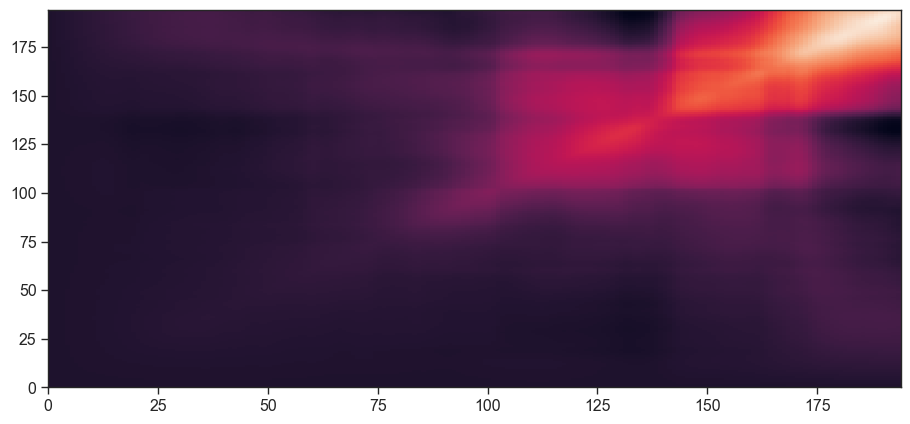

In [977]:
plt.pcolormesh( np.cov(dat.u*dat.x,rowvar=True) )

In [426]:
from scipy.spatial import ConvexHull, convex_hull_plot_2d

In [938]:
xi, yi = make_n_hexs(0.1, 3, 1, 6)

fu=fu_list[0]
fv=fv_list[0]
fzeta=fzeta_list[0]
# find the u,v at the polygon vertices
ui = fu.ev(xi, yi)
vi = fv.ev(xi, yi)
zeta = fzeta.ev(xi, yi)

In [939]:
f= gsw.f(17)

dt=1

urot = vi
vrot = ui

xi_n = xi + dt*urot/1000
yi_n = yi + dt*vrot/1000
points = np.squeeze( np.array( [xi, yi] ) ).T
points_n = np.squeeze( np.array( [xi_n, yi_n] ) ).T

hull = ConvexHull(points)
hull_n = ConvexHull(points_n)
area = ConvexHull(points).area
area_n = ConvexHull(points_n).area

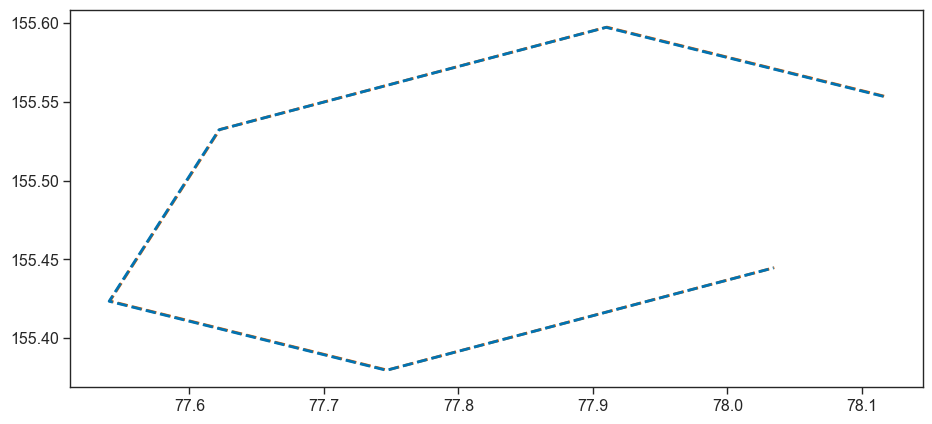

In [940]:
plt.plot(points[hull.vertices,0], points[hull.vertices,1], 'r--', lw=2)
plt.plot(points_n[hull_n.vertices,0], points_n[hull_n.vertices,1], 'b--', lw=2)

In [941]:
def in_hull(p, hull):
    """
    Test if points in `p` are in `hull`

    `p` should be a `NxK` coordinates of `N` points in `K` dimensions
    `hull` is either a scipy.spatial.Delaunay object or the `MxK` array of the 
    coordinates of `M` points in `K`dimensions for which Delaunay triangulation
    will be computed
    """
    from scipy.spatial import Delaunay
    if not isinstance(hull,Delaunay):
        hull = Delaunay(hull)

    return hull.find_simplex(p)>=0

In [942]:
from scipy.spatial import Delaunay
hull = Delaunay(points)

In [950]:
xtest = np.arange(np.min(points[:,0]),np.max(points[:,0]),0.001)
ytest = np.arange(np.min(points[:,1]),np.max(points[:,1]),0.001)

In [951]:
x,y = np.meshgrid(xtest,ytest)

In [952]:
mod_points = np.stack( [x.flatten(), y.flatten()]).T

In [953]:
bol = in_hull(mod_points,hull)

In [954]:
np.sum(bol==True)

77939

In [955]:
sel = mod_points[bol]

In [961]:
np.sum( fzeta.ev(sel[:,0],sel[:,1])/f )/area

-55982.04838749876

In [960]:
np.sum( fzeta.ev(points[:,0],points[:,1])/f)/area

-4.307348202080684

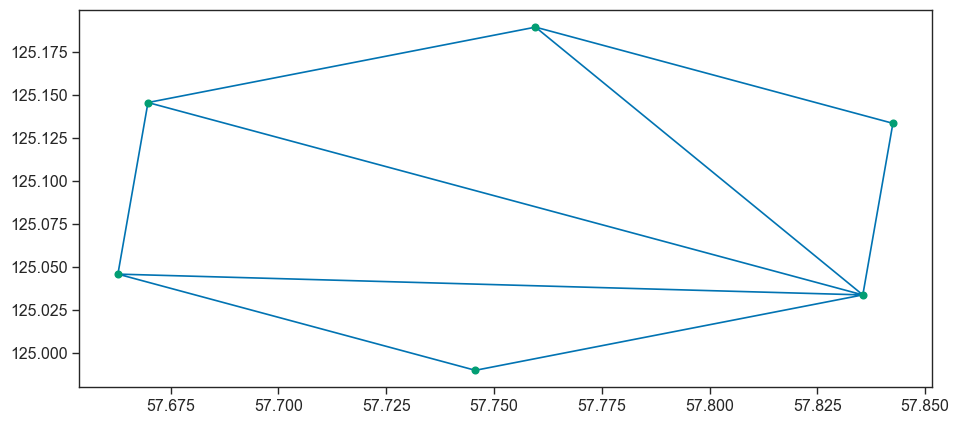

In [865]:
import matplotlib.pyplot as plt
plt.triplot(points[:,0], points[:,1], tri.simplices)
plt.plot(points[:,0], points[:,1], 'o')
plt.show()

In [587]:
def saucier(x,y,u,v):
    f= gsw.f(17)

    dt=0.1

    urot = v
    vrot = -u

    xi_n = x + dt*urot/1000
    yi_n = y + dt*vrot/1000
    points = np.squeeze( np.array( [x, y] ) ).T
    points_n = np.squeeze( np.array( [xi_n, yi_n] ) ).T

    hull = ConvexHull(points)
    hull_n = ConvexHull(points_n)
    area = ConvexHull(points).area
    area_n = ConvexHull(points_n).area
    
    return (area_n - area)/area/dt/f

In [713]:
def kawai(x,y,u,v):
    f= gsw.f(17)
    uvec = np.append(u,u[0])
    vvec = np.append(v,v[0])
    xvec = np.append(x,x[0])
    yvec = np.append(y,y[0])

    umean = np.array( [np.mean(uvec[i:i+2]) for i in range(u.size) ])
    vmean = np.array( [np.mean(vvec[i:i+2]) for i in range(v.size) ])

    rx = np.array( [ xvec[i+1]-xvec[i] for i in range(x.size) ])*1000
    ry = np.array( [ yvec[i+1]-yvec[i] for i in range(y.size) ])*1000
    
    points = np.squeeze( np.array( [x, y] ) ).T
    area = ConvexHull(points).area

    return np.sum( umean*rx + vmean*ry )/f/(1e6*area)

In [966]:
f= gsw.f(17)
N=10000
M=6
L=1
S=1
xi, yi = make_n_hexs(L, S, N, M)

fu=fu_list[0]
fv=fv_list[0]
fzeta=fzeta_list[0]
# find the u,v at the polygon vertices
ui = fu.ev(xi, yi)
vi = fv.ev(xi, yi)
zeta = fzeta.ev(xi, yi)

LS=[]
SAU = []
TRUE = []
KAW = []
for i in range(N):
    LS.append( least_square_method( xi[i,:], yi[i,:], ui[i,:], vi[i,:], 'lstsq'))
    SAU.append( saucier(xi[i,:], yi[i,:], ui[i,:], vi[i,:]))
    TRUE.append( np.nanmean( zeta[i,:])/f)
    KAW.append( kawai(xi[i,:], yi[i,:], ui[i,:], vi[i,:]))
    
LS = np.array(LS).squeeze()[:,0]
SAU = np.array(SAU)
TRUE = np.array(TRUE)
KAW = np.array(KAW)

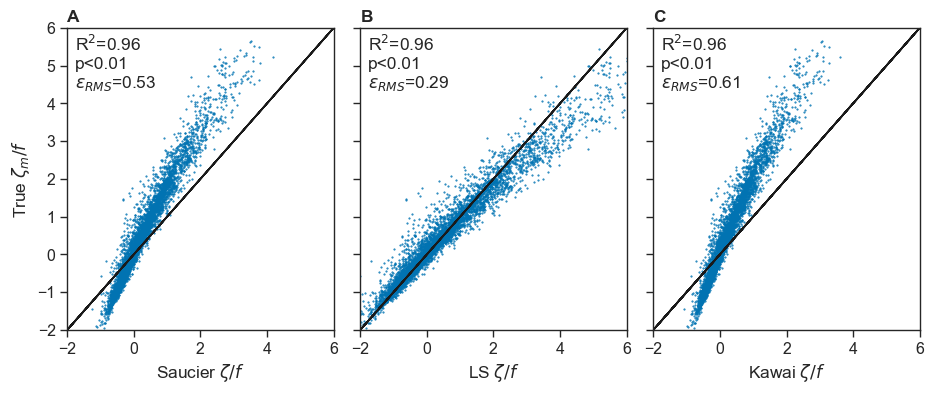

In [967]:
fig,ax = plt.subplots(1,3, sharey=True,figsize=(11,4))
ax[0].plot(SAU,TRUE,'.', markersize=1)
ax[0].plot(TRUE,TRUE,color='k')
ax[0].set_ylim(-2,6)
ax[0].set_xlim(-2,6)
ax[0].set_ylabel('True $\zeta_m/f$')
ax[0].set_xlabel('Saucier $\zeta/f$')

r,p = pearsonr(SAU, TRUE)
e = np.sqrt( np.mean( (SAU-TRUE)**2 ) )
r2=r**2
ax[0].annotate(rf'R$^2$={r2:2.2f}'+'\n'+r'p<0.01'+'\n'+rf'$\epsilon_{{RMS}}$={e:2.2f}',(0.03,0.8),xycoords='axes fraction')


ax[1].plot(LS,TRUE,'.', markersize=1)
ax[1].plot(TRUE,TRUE,color='k')
ax[1].set_ylim(-2,6)
ax[1].set_xlim(-2,6)
ax[1].set_xlabel('LS $\zeta/f$')

r,p = pearsonr(LS, TRUE)
e = np.sqrt( np.mean( (LS-TRUE)**2 ) )
r2=r**2
ax[1].annotate(rf'R$^2$={r2:2.2f}'+'\n'+r'p<0.01'+'\n'+rf'$\epsilon_{{RMS}}$={e:2.2f}',(0.03,0.8),xycoords='axes fraction')

ax[2].plot(KAW,TRUE,'.', markersize=1)
ax[2].plot(TRUE,TRUE,color='k')
ax[2].set_ylim(-2,6)
ax[2].set_xlim(-2,6)
ax[2].set_xlabel('Kawai $\zeta/f$')

r,p = pearsonr(KAW, TRUE)
e = np.sqrt( np.mean( (KAW-TRUE)**2 ) )
r2=r**2
ax[2].annotate(rf'R$^2$={r2:2.2f}'+'\n'+r'p<0.01'+'\n'+rf'$\epsilon_{{RMS}}$={e:2.2f}',(0.03,0.8),xycoords='axes fraction')

plt.subplots_adjust(wspace=0.1)

alphabet(ax)

plt.savefig('../figures/compare_methods.pdf',dpi=600)